In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import psycopg2
import config
from datetime import datetime
from psycopg2.extras import execute_values
from sklearn.svm import SVC
import os
import sys

In [3]:
conn = psycopg2.connect(dbname=config.redshift['dbname'],
                            host=config.redshift['host'],
                            port=config.redshift['port'],
                            user=config.redshift['user'],
                            password=config.redshift['password'])

In [4]:
with open('sql/inventory_mix.sql','r') as f:
            sql = f.read()

In [5]:
df = pd.read_sql(sql, conn)

In [6]:
df.head(3)

,date_start,date_end,week_start,day_of_week,month,region,on_website,vin,model,model_year,alg_trim,color,is_reserved,daily_spend,number_available_cars
0,2017-12-15,2017-12-15 23:59:59,2017-12-11,Friday,Dec,Los Angeles,Available,3FA6P0H72FR206510,Fusion,2015.0,4dr Sdn SE,Blue,0,1761.72,27
1,2017-12-15,2017-12-15 23:59:59,2017-12-11,Friday,Dec,Los Angeles,Available,1FMCU0J98FUA25899,Escape,2015.0,4dr Wgn Titanium,Grey,0,1761.72,27
2,2017-12-15,2017-12-15 23:59:59,2017-12-11,Friday,Dec,Los Angeles,Available,1FM5K7D82FGC65314,Explorer,2015.0,4dr Wgn XLT,Brown,0,1761.72,27


In [23]:
conn.close()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 15 columns):
date_start               23422 non-null datetime64[ns]
date_end                 23422 non-null datetime64[ns]
week_start               23422 non-null datetime64[ns]
day_of_week              23422 non-null object
month                    23422 non-null object
region                   23421 non-null object
on_website               23421 non-null object
vin                      23421 non-null object
model                    23421 non-null object
model_year               23421 non-null float64
alg_trim                 23421 non-null object
color                    23421 non-null object
is_reserved              23422 non-null int64
daily_spend              23422 non-null float64
number_available_cars    23422 non-null int64
dtypes: datetime64[ns](3), float64(2), int64(2), object(8)
memory usage: 2.7+ MB


In [8]:
model_list = ['Focus','Fusion','Fiesta','Escape','C-Max Hybrid','Explorer','Edge','Mustang']

for var in model_list:
    daily_counts = df[df['model']==var].groupby(['date_start','region'])['vin'].count().reset_index()
    daily_counts = pd.DataFrame(daily_counts)
    daily_counts.columns = ['date_start', 'region', (str(var) + '_count').lower()]

    df = pd.merge(df, daily_counts, how='left', on=['date_start','region'])

In [9]:
df.columns

Index(['date_start', 'date_end', 'week_start', 'day_of_week', 'month',
       'region', 'on_website', 'vin', 'model', 'model_year', 'alg_trim',
       'color', 'is_reserved', 'daily_spend', 'number_available_cars',
       'focus_count', 'fusion_count', 'fiesta_count', 'escape_count',
       'c-max hybrid_count', 'explorer_count', 'edge_count', 'mustang_count'],
      dtype='object')

In [10]:
target = ['is_reserved']
num_cols = ['daily_spend', 'number_available_cars','focus_count', 'fusion_count', 'fiesta_count', 'escape_count',
               'c-max hybrid_count', 'explorer_count', 'edge_count', 'mustang_count']
cat_cols = ['region', 'day_of_week', 'month', 'model', 'model_year', 'alg_trim', 'color']
features = num_cols + cat_cols

In [11]:
for var in cat_cols:
    label = LabelEncoder()
    df[var] = label.fit_transform(df[var].astype('str'))

In [12]:
features = df[features].fillna(0)
target = df[target].values.ravel()

In [13]:
features.describe()

,daily_spend,number_available_cars,focus_count,fusion_count,fiesta_count,escape_count,c-max hybrid_count,explorer_count,edge_count,mustang_count,region,day_of_week,month,model,model_year,alg_trim,color
count,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000,23422.000000
mean,2138.329019,38.560456,2.971181,7.826659,1.246051,10.752284,0.734694,4.860943,2.120869,2.011613,1.189096,3.007600,5.577150,6.271625,0.270003,26.980147,5.788063
std,740.459027,15.800588,2.330030,4.723435,1.342901,5.286371,0.889895,3.390690,1.593650,1.873581,0.981958,2.027359,3.662039,3.651355,0.623621,12.386855,3.367237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1569.030000,26.000000,1.000000,4.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000,15.000000,5.000000
50%,2042.660000,36.000000,3.000000,7.000000,1.000000,11.000000,1.000000,4.000000,2.000000,2.000000,2.000000,3.000000,6.000000,5.000000,0.000000,30.000000,7.000000
75%,2696.262422,49.000000,5.000000,11.000000,2.000000,15.000000,1.000000,7.000000,3.000000,3.000000,2.000000,5.000000,9.000000,9.000000,0.000000,38.000000,9.000000
max,4693.320000,76.000000,10.000000,20.000000,6.000000,23.000000,4.000000,13.000000,7.000000,8.000000,2.000000,6.000000,11.000000,16.000000,3.000000,52.000000,10.000000


In [14]:
X1 = features
y1 = target

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.5, random_state=101)

In [16]:
y_train = y_train.ravel()

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [17]:
model = SVC(C=0.1, gamma=1, kernel='rbf')

In [18]:
model.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
predictions = model.predict(X_test)
pred = pd.DataFrame(predictions)
pred[0].value_counts()

0    11711
Name: 0, dtype: int64

In [20]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[10672     0]
 [ 1039     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10672
           1       0.00      0.00      0.00      1039

   micro avg       0.91      0.91      0.91     11711
   macro avg       0.46      0.50      0.48     11711
weighted avg       0.83      0.91      0.87     11711



/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
# param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [76]:
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=3)

In [85]:
# grid.fit(X_train,y_train)

In [78]:
grid.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

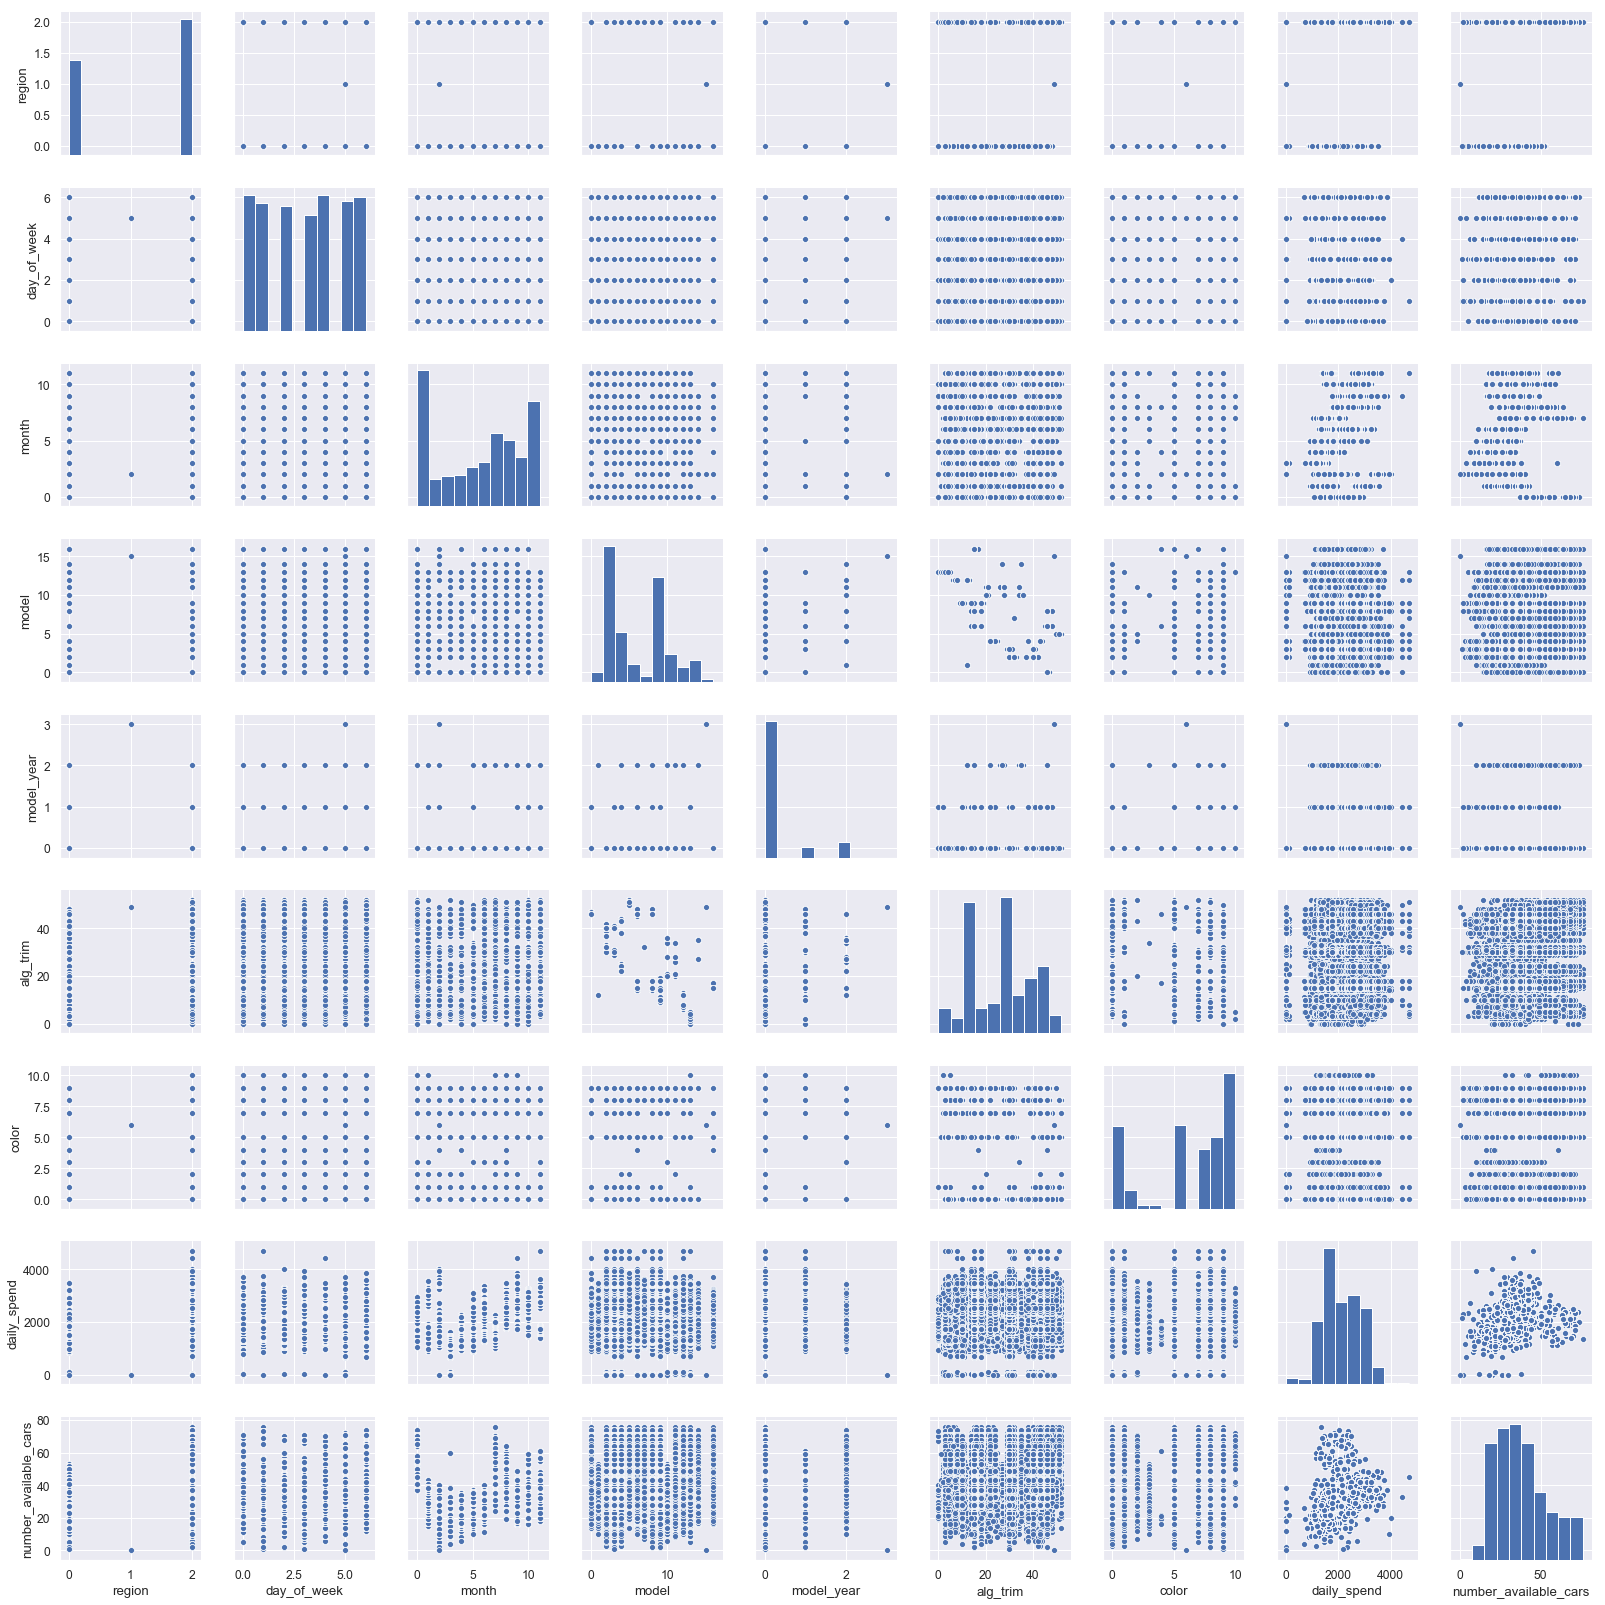

In [246]:
sns.pairplot(features)

In [21]:
from sklearn.linear_model import LogisticRegression
import statsmodels.discrete.discrete_model as sm

In [22]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.686407
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: -1.350    
Dependent Variable: y                AIC:              16111.0224
Date:               2018-12-18 10:01 BIC:              16236.2832
No. Observations:   11711            Log-Likelihood:   -8038.5   
Df Model:           16               LL-Null:          -3421.3   
Df Residuals:       11694            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        -0.0108     0.0234   -0.4638   0.6428   -0.0567    0.0350
x2         0.0808     0.0945    0.8551   0.3925   -0.1045 

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
logreg = LogisticRegression(solver='warn')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[10672     0]
 [ 1039     0]]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10672
           1       0.00      0.00      0.00      1039

   micro avg       0.91      0.91      0.91     11711
   macro avg       0.46      0.50      0.48     11711
weighted avg       0.83      0.91      0.87     11711



/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
conn = psycopg2.connect(dbname=config.redshift['dbname'],
                            host=config.redshift['host'],
                            port=config.redshift['port'],
                            user=config.redshift['user'],
                            password=config.redshift['password'])

In [27]:
with open('sql/reservations.sql','r') as f:
            sql = f.read()

In [28]:
df = pd.read_sql(sql, conn)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 0 to 702
Data columns (total 35 columns):
date_start             702 non-null datetime64[ns]
region                 702 non-null int64
day_num                702 non-null int64
week_num               702 non-null object
month                  702 non-null object
daily_spend            702 non-null float64
cars_available         702 non-null int64
reservations           702 non-null int64
focus                  702 non-null int64
fusion                 702 non-null int64
escape                 702 non-null int64
explorer               702 non-null int64
edge                   702 non-null int64
mustang                702 non-null int64
cmax_hybrid            702 non-null int64
fiesta                 702 non-null int64
other                  702 non-null int64
my_2015                702 non-null int64
my_2016                702 non-null int64
my_2017                702 non-null int64
proportion_reserved    702 non-null float6

In [34]:
df[['cars_available','focus','fusion','escape','explorer','edge','mustang','cmax_hybrid','fiesta','other','my_2015','my_2016','my_2017']].describe()

,cars_available,focus,fusion,escape,explorer,edge,mustang,cmax_hybrid,fiesta,other,my_2015,my_2016,my_2017
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000
mean,32.034188,2.296296,6.353276,9.160969,4.004274,1.764957,1.438746,0.559829,0.937322,5.518519,26.257835,2.592593,3.183761
std,14.672029,2.105075,4.555630,5.192007,3.106063,1.484210,1.608140,0.785920,1.167341,4.402901,15.516515,4.293691,4.124540
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,1.000000,3.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,15.000000,0.000000,0.000000
50%,29.000000,2.000000,5.000000,8.000000,3.500000,2.000000,1.000000,0.000000,1.000000,5.000000,24.000000,0.000000,1.000000
75%,41.000000,3.000000,9.000000,13.000000,6.000000,3.000000,2.000000,1.000000,2.000000,8.000000,33.000000,3.000000,7.000000
max,76.000000,10.000000,20.000000,23.000000,13.000000,7.000000,7.000000,4.000000,6.000000,17.000000,76.000000,22.000000,12.000000


In [33]:
df = df[df['cars_available']>0]

In [35]:
df['proportion_reserved'] = df['reservations'] / df['cars_available']
df['rolling_avg_spend'] = df['daily_spend'].rolling(10, min_periods=1).mean()
df['season'] = df['month'].apply(lambda x: 'winter' if np.isin(x, ['Dec','Jan','Feb']) == True
                                    else ('spring' if np.isin(x, ['Mar','Apr','May']) == True
                                    else ('summer' if np.isin(x, ['Jun','Jul','Aug']) == True
                                    else 'fall')))

listvar = ['focus','fusion','escape','explorer','edge','mustang','cmax_hybrid','fiesta','other','my_2015','my_2016','my_2017']
for var in listvar:
    new_prop = df[var] / df['cars_available']
    new_prop = pd.DataFrame(new_prop, columns=[('prop_' + str(var)).lower()])
    df = pd.merge(df, new_prop, left_index=True, right_index=True)

In [37]:
target = ['proportion_reserved']
num_cols = ['cars_available', 'rolling_avg_spend', 'prop_focus', 'prop_fusion', 'prop_escape',
            'prop_explorer', 'prop_edge', 'prop_mustang', 'prop_cmax_hybrid', 'prop_fiesta',
            'prop_other', 'prop_my_2015', 'prop_my_2016','prop_my_2017']
cat_cols = ['region', 'season']
features = num_cols + cat_cols
for var in cat_cols:
    label = LabelEncoder()
    df[var] = label.fit_transform(df[var].astype('str'))

In [101]:
X = df[features].fillna(0)
y = df[target].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=101,
                                                    test_size=0.33)
df[target].describe()

,proportion_reserved
count,702.000000
mean,1.096607
std,0.106673
min,1.000000
25%,1.035714
50%,1.068574
75%,1.120909
max,2.000000


In [99]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (470, 16)
Training Labels Shape: (470,)
Testing Features Shape: (232, 16)
Testing Labels Shape: (232,)


In [104]:
from sklearn.ensemble import RandomForestRegressor

m = RandomForestRegressor(n_estimators=100, max_depth=25, criterion='mse',
                            min_samples_leaf=3, min_samples_split=5)

model = m.fit(X_train, y_train)

# Make predictions on test data
predictions = model.predict(X_test)

# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Expanded Data')
n = len(y_test)

# Calculate weighted mean absolute percentage error (MAPE)
wmape = ((np.sum(errors) / np.sum(y_test)) * (100 / n))

# Calculate and display accuracy
accuracy = 100 - wmape
print('Accuracy:', round(accuracy, 2), '%')

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Metrics for Random Forest Trained on Expanded Data
Accuracy: 99.75 %
Mean Absolute Error: 0.05


In [106]:
# Get numerical feature importances
importances = list(m.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: cars_available       Importance: 0.26
Variable: region               Importance: 0.19
Variable: prop_escape          Importance: 0.14
Variable: rolling_avg_spend    Importance: 0.07
Variable: prop_fusion          Importance: 0.07
Variable: prop_other           Importance: 0.06
Variable: prop_my_2015         Importance: 0.04
Variable: prop_explorer        Importance: 0.03
Variable: prop_mustang         Importance: 0.03
Variable: prop_my_2016         Importance: 0.03
Variable: prop_focus           Importance: 0.02
Variable: prop_edge            Importance: 0.02
Variable: season               Importance: 0.02
Variable: prop_cmax_hybrid     Importance: 0.01
Variable: prop_fiesta          Importance: 0.01
Variable: prop_my_2017         Importance: 0.01


Text(0.5, 1.0, 'Variable Importances')

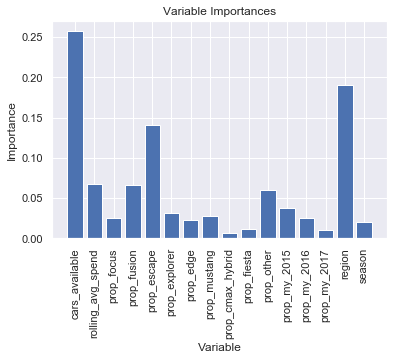

In [107]:
sns.set(style='darkgrid')
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance') 
plt.xlabel('Variable')
plt.title('Variable Importances')

Text(0.5, 1.0, 'Actual and Predicted Values')

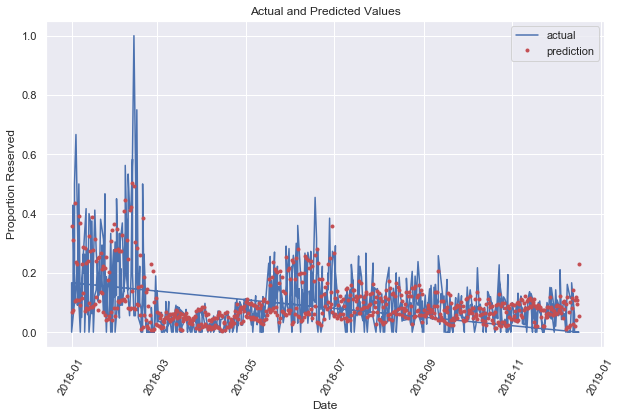

In [109]:
# Use datetime for creating date objects for plotting
import datetime

sns.set(style='darkgrid')

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': df['date_start'], 'actual': df['proportion_reserved']})

# Dataframe with predictions and dates
predictions = model.predict(X)
predictions_data = pd.DataFrame(data = {'date': df['date_start'], 'prediction': predictions})

fig, ax = plt.subplots(figsize=(10,6))
# Plot the actual values
ax.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
ax.plot(predictions_data['date'], predictions_data['prediction'], 'ro', markersize=3, label = 'prediction')

plt.xticks(rotation = '60')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Proportion Reserved')
plt.title('Actual and Predicted Values')

In [110]:
check_diff = pd.DataFrame(predictions - df['proportion_reserved'])
check_diff.columns = ['difference']
check_diff.describe()

,difference
count,702.000000
mean,0.000764
std,0.059942
min,-0.507681
25%,-0.018236
50%,0.004996
75%,0.025237
max,0.366669


In [120]:
param_grid = {"max_features" : ["auto", "sqrt", "log2"],
              "n_estimators" : [10, 50, 100],
              "max_depth" : [30, 40, 50, 60, 70],
              "min_samples_leaf" : [30, 40, 50, 100],
              "min_samples_split" : [2, 5, 10]}

In [121]:
CV = GridSearchCV(estimator=m, param_grid=param_grid, cv=5, n_jobs=-1)

In [122]:
CV.fit(X_train, y_train)
print("\nBest Params:")
print(CV.best_params_)


Best Params:
{'max_depth': 70, 'max_features': 'auto', 'min_samples_leaf': 30, 'min_samples_split': 5, 'n_estimators': 10}


In [53]:
conn.close()

In [6]:
rv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 20 columns):
date_start        732 non-null datetime64[ns]
region            732 non-null object
day_num           732 non-null int64
week_num          732 non-null object
month             732 non-null object
daily_spend       732 non-null float64
cars_available    732 non-null int64
reservations      732 non-null int64
focus             732 non-null int64
fusion            732 non-null int64
escape            732 non-null int64
explorer          732 non-null int64
edge              732 non-null int64
mustang           732 non-null int64
cmax_hybrid       732 non-null int64
fiesta            732 non-null int64
other             732 non-null int64
my_2015           732 non-null int64
my_2016           732 non-null int64
my_2017           732 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(15), object(3)
memory usage: 114.5+ KB


In [113]:
rv['proportion_reserved'] = rv['reservations']/rv['cars_available']

In [8]:
rv.corr()

,day_num,daily_spend,cars_available,reservations,focus,fusion,escape,explorer,edge,mustang,cmax_hybrid,fiesta,other,my_2015,my_2016,my_2017,proportion_reserved
day_num,1.000000,-0.079047,-0.029399,-0.004566,-0.029847,-0.052528,-0.042774,0.029834,0.069756,0.063315,-0.000181,-0.153089,-0.008909,-0.017686,-0.038408,-0.004576,-0.015923
daily_spend,-0.079047,1.000000,0.315080,0.182291,0.327889,0.434820,0.240938,0.025651,-0.061384,0.045889,0.172470,0.070269,0.115325,0.173214,0.429447,0.094405,-0.057712
cars_available,-0.029399,0.315080,1.000000,0.208184,0.632157,0.731249,0.737218,0.571201,0.403146,0.722712,0.429583,0.572961,0.388520,0.937969,0.075977,-0.025149,-0.235075
reservations,-0.004566,0.182291,0.208184,1.000000,0.251305,0.227695,0.351821,0.045242,0.074327,0.160755,0.029821,0.104504,-0.213410,0.294646,-0.019038,-0.345389,0.764864
focus,-0.029847,0.327889,0.632157,0.251305,1.000000,0.586133,0.324274,0.397995,0.140920,0.385976,0.229785,0.361995,0.058091,0.550376,0.322232,-0.096402,-0.027565
fusion,-0.052528,0.434820,0.731249,0.227695,0.586133,1.000000,0.470135,0.289892,0.167443,0.395249,0.304681,0.343875,0.063562,0.654720,0.328011,-0.139870,-0.135663
escape,-0.042774,0.240938,0.737218,0.351821,0.324274,0.470135,1.000000,0.185849,0.256851,0.534240,0.151821,0.441423,0.084079,0.800340,-0.149856,-0.244825,-0.058968
explorer,0.029834,0.025651,0.571201,0.045242,0.397995,0.289892,0.185849,1.000000,0.503097,0.468583,0.358570,0.265742,0.021853,0.542465,0.314136,-0.275545,-0.172192
edge,0.069756,-0.061384,0.403146,0.074327,0.140920,0.167443,0.256851,0.503097,1.000000,0.465969,0.359404,0.241405,-0.187438,0.526243,-0.105355,-0.443762,-0.075787
mustang,0.063315,0.045889,0.722712,0.160755,0.385976,0.395249,0.534240,0.468583,0.465969,1.000000,0.324013,0.394010,0.173680,0.776099,-0.121471,-0.230530,-0.093742


/Users/halliecramer/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


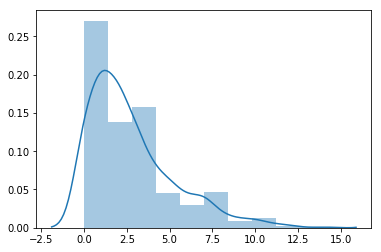

In [9]:
sns.distplot(rv[['reservations']], bins=10)

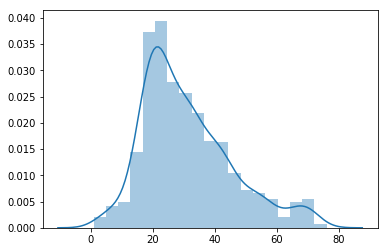

In [10]:
sns.distplot(rv[['cars_available']])

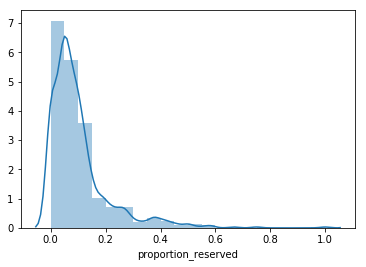

In [18]:
sns.distplot(rv['proportion_reserved'], bins=20)

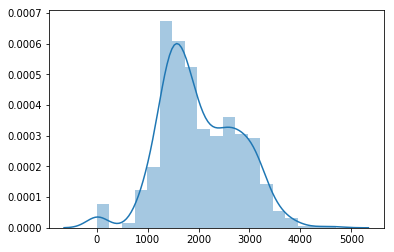

In [12]:
sns.distplot(rv[['daily_spend']])

In [13]:
rv['ln_prop_reservations'] = rv['proportion_reserved'].apply(lambda x: np.log(x+1))

In [14]:
rv[['reservations', 'ln_prop_reservations']].head(10)

,reservations,ln_prop_reservations
0,2,0.066691
1,9,0.307485
2,2,0.080043
3,1,0.036368
4,1,0.040822
5,2,0.154151
6,2,0.087011
7,11,0.377294
8,11,0.341749
9,12,0.356675


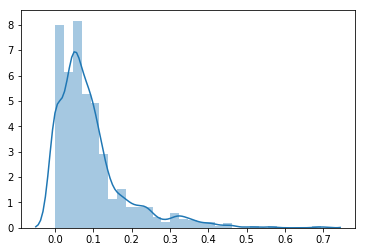

In [17]:
sns.distplot(rv[['ln_prop_reservations']], bins = 30,)

In [114]:
rv['rolling_avg_spend'] = rv['daily_spend'].rolling(10, min_periods=1).mean()
rv['rolling_avg_spend'].describe()

count     732.000000
mean     2013.165600
std       562.951836
min       260.373000
25%      1570.996750
50%      2019.265000
75%      2468.818000
max      3080.282000
Name: rolling_avg_spend, dtype: float64

In [115]:
def season(month):
    if np.isin(month, ['Dec','Jan','Feb']) == True:
        return 'winter'
    elif np.isin(month, ['Mar','Apr','May']) == True:
        return 'spring'
    elif np.isin(month, ['Jun','Jul','Aug']) == True:
        return 'summer'
    else:
        return 'fall'

rv['season'] = rv['month'].apply(lambda x: season(x))

In [116]:
rv['year'] = rv['date_start'].apply(lambda x: x.year)

In [117]:
mylist = ['focus','fusion','escape','explorer','edge','mustang','cmax_hybrid','fiesta','other','my_2015','my_2016','my_2017']

for var in mylist:
    new_prop = rv[var] / rv['cars_available']
    new_prop = pd.DataFrame(new_prop, columns=[('prop_' + str(var)).lower()])
    rv = pd.merge(rv, new_prop, left_index=True, right_index=True)

In [118]:
rv.head()

,date_start,region,day_num,week_num,month,daily_spend,cars_available,reservations,focus,fusion,...,prop_escape,prop_explorer,prop_edge,prop_mustang,prop_cmax_hybrid,prop_fiesta,prop_other,prop_my_2015,prop_my_2016,prop_my_2017
0,2017-12-14,San Francisco Bay Area,14,2,Dec,1313.99,25,9,3,7,...,0.240000,0.000000,0.040000,0.240000,0.000000,0.000000,0.080000,1.0,0.0,0.0
1,2017-12-14,Los Angeles,14,2,Dec,1290.66,29,2,4,5,...,0.206897,0.275862,0.137931,0.034483,0.034483,0.000000,0.000000,1.0,0.0,0.0
2,2017-12-15,Los Angeles,15,2,Dec,1761.72,27,1,3,5,...,0.185185,0.296296,0.148148,0.037037,0.037037,0.000000,0.000000,1.0,0.0,0.0
3,2017-12-16,Los Angeles,16,2,Dec,1595.77,27,1,3,5,...,0.148148,0.296296,0.148148,0.037037,0.037037,0.037037,0.000000,1.0,0.0,0.0
4,2017-12-17,San Francisco Bay Area,17,2,Dec,1657.05,12,2,1,4,...,0.000000,0.000000,0.083333,0.333333,0.000000,0.000000,0.166667,1.0,0.0,0.0


In [119]:
dummies1 = pd.get_dummies(rv['season'])
dummies2 = pd.get_dummies(rv['region'])
rv['week_num'] = rv['week_num'].astype(int)

reg = pd.concat([rv, dummies1, dummies2], axis=1)
reg = reg[reg['year']==2018]
reg.describe()

,day_num,week_num,daily_spend,cars_available,reservations,focus,fusion,escape,explorer,edge,...,prop_other,prop_my_2015,prop_my_2016,prop_my_2017,fall,spring,summer,winter,Los Angeles,San Francisco Bay Area
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,...,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.00000,696.00000
mean,15.364943,2.663793,2041.800750,31.817529,2.741379,2.297414,6.206897,9.178161,4.015805,1.780172,...,0.182810,0.801544,0.080783,0.117674,0.261494,0.264368,0.264368,0.209770,0.50000,0.50000
std,8.796443,1.278110,766.151148,14.496729,2.446389,2.104957,4.296260,5.168236,3.113865,1.481476,...,0.148943,0.203812,0.116159,0.154220,0.439765,0.441313,0.441313,0.407437,0.50036,0.50036
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.240000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,8.000000,2.000000,1474.537500,21.000000,1.000000,1.000000,3.000000,5.000000,1.000000,0.000000,...,0.064516,0.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,15.000000,3.000000,1912.880000,29.000000,2.000000,2.000000,5.000000,8.000000,4.000000,2.000000,...,0.138410,0.900000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.50000,0.50000
75%,23.000000,4.000000,2639.886850,40.000000,4.000000,3.000000,9.000000,13.000000,6.000000,3.000000,...,0.270105,1.000000,0.121212,0.263158,1.000000,1.000000,1.000000,0.000000,1.00000,1.00000
max,31.000000,5.000000,4693.320000,76.000000,14.000000,10.000000,19.000000,23.000000,13.000000,7.000000,...,0.650000,1.000000,0.500000,0.600000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


In [120]:
reg.columns

Index(['date_start', 'region', 'day_num', 'week_num', 'month', 'daily_spend',
       'cars_available', 'reservations', 'focus', 'fusion', 'escape',
       'explorer', 'edge', 'mustang', 'cmax_hybrid', 'fiesta', 'other',
       'my_2015', 'my_2016', 'my_2017', 'proportion_reserved',
       'rolling_avg_spend', 'season', 'year', 'prop_focus', 'prop_fusion',
       'prop_escape', 'prop_explorer', 'prop_edge', 'prop_mustang',
       'prop_cmax_hybrid', 'prop_fiesta', 'prop_other', 'prop_my_2015',
       'prop_my_2016', 'prop_my_2017', 'fall', 'spring', 'summer', 'winter',
       'Los Angeles', 'San Francisco Bay Area'],
      dtype='object')

In [123]:
X = reg[['day_num', 'week_num', 'rolling_avg_spend', 'cars_available', 
           'prop_focus', 'prop_fusion',
           'prop_escape', 'prop_explorer', 'prop_edge', 'prop_mustang',
           'prop_cmax_hybrid', 'prop_fiesta', 'prop_other', 
           'prop_my_2015', 'prop_my_2016','prop_my_2017', 
           'spring', 'summer', 'fall', 'Los Angeles']]
# X = reg[['rolling_avg_spend', 'focus', 'fusion', 'escape', 'cars_available', 
#             'my_2016', 'my_2017', 'spring', 'summer', 'fall', 'Los Angeles']]
y = reg[['proportion_reserved']]
# y = reg['ln_reservations']

In [106]:
# fig, ax = plt.subplots(figsize=(28,16))
# sns.heatmap(reg.corr(), cmap='coolwarm', annot=True)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [31]:
import statsmodels.api as sm 

In [151]:
# reg.info()

In [88]:
X_train = sm.add_constant(X_train) ## let's add an intercept (beta_0) to our model
X_test = sm.add_constant(X_test)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit() ## sm.OLS(output, input)
ols_preds = model.predict(X_test)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     proportion_reserved   R-squared:                       0.419
Model:                             OLS   Adj. R-squared:                  0.397
Method:                  Least Squares   F-statistic:                     18.78
Date:                 Fri, 14 Dec 2018   Prob (F-statistic):           1.43e-44
Time:                         14:45:54   Log-Likelihood:                 554.52
No. Observations:                  487   AIC:                            -1071.
Df Residuals:                      468   BIC:                            -991.5
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0916      0.032      2.853      0.005       0.029       0.155
day_num              -0.0004      0.000     -0.855      0.393      -0.001       0.001
week_num              0.0028      0.003      0.851      0.395      -0.004       0.009
rolling_avg_spend  5.959e-06   8.64e-06      0.689      0.491    -1.1e-05    2.29e-05
cars_available       -0.0035      0.000     -7.269      0.000      -0.004      -0.003
prop_focus            0.1200      0.064      1.884      0.060      -0.005       0.245
prop_fusion           0.0464      0.046      1.018      0.309      -0.043       0.136
prop_escape           0.0018      0.043      0.043      0.966      -0.082       0.085
prop_explorer         0.0620      0.064      0.969      0.333      -0.064       0.188
prop_edge            -0.2657      0.102     -2.595      0.010      -0.467      -0.064
prop_mustang         -0.0539      0.106     -0.509      0.611      -0.262       0.154
prop_cmax_hybrid     -0.0388      0.146     -0.265      0.791      -0.326       0.248
prop_fiesta          -0.0289      0.112     -0.258      0.796      -0.249       0.191
prop_other            0.2487      0.067      3.694      0.000       0.116       0.381
prop_2015             0.1794      0.027      6.741      0.000       0.127       0.232
prop_2016            -0.0519      0.046     -1.131      0.259      -0.142       0.038
prop_2017            -0.0359      0.067     -0.535      0.593      -0.168       0.096
spring               -0.0346      0.019     -1.800      0.072      -0.072       0.003
summer               -0.0372      0.016     -2.282      0.023      -0.069      -0.005
fall                 -0.0223      0.017     -1.292      0.197      -0.056       0.012
Los Angeles          -0.1189      0.015     -8.117      0.000      -0.148      -0.090
==============================================================================
Omnibus:                       91.971   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.640
Skew:                           0.739   Prob(JB):                     8.36e-94
Kurtosis:                       7.352   Cond. No.                     5.04e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.55e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Predicted Reservations')

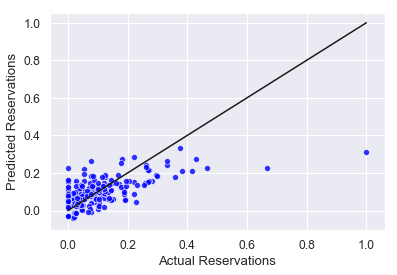

In [91]:
sns.set(font_scale=1.1)
x = np.asarray(range(0,2))
y = np.asarray(range(0,2))
plt.plot(x, y, color='k')
sns.regplot(y_test, ols_preds, fit_reg=False, color='#0000ff', scatter_kws={"edgecolor":'w', "linewidth": 0.7})
plt.xlabel('Actual Reservations')
plt.ylabel('Predicted Reservations')

In [92]:
reg['reservations'].describe()

count    696.000000
mean       2.741379
std        2.446389
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       14.000000
Name: reservations, dtype: float64

In [185]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Fit regression model
dtr = DecisionTreeRegressor(max_depth=2, min_samples_split=6, min_samples_leaf=5)
dtr.fit(X_train, y_train)

# Predict
y_pred =dtr.predict(X_test)
print(dtr.feature_importances_)

# Get Metrics
dt_scores = cross_val_score(dtr, X_train, y_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dtr.score(X_train, y_train)))
print("root mean squared error: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

# on the test or hold-out set
print(dtr.score(X_test, y_test))


[0.         0.         0.         0.54505623 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02076212 0.
 0.         0.43418165]
mean cross validation score: 0.30758650771705465
score without cv: 0.3498531921739485
root mean squared error: 0.09107193283283715
0.39208739982560653


In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix().ravel(), test_size=0.3, random_state=101)

# Fit regression model
rfr = RandomForestRegressor(max_depth=2, n_estimators=100, min_samples_split=8, min_samples_leaf=5)
rfr.fit(X_train, y_train)

# Predict
y_pred = rfr.predict(X_test)

# Get Metrics
dt_scores = cross_val_score(rfr, X_train, y_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(rfr.score(X_train, y_train)))
print("root mean squared error: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

# on the test or hold-out set
print(rfr.score(X_test, y_test))

/Users/halliecramer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


mean cross validation score: 0.3228883254413669
score without cv: 0.40202153032286236
root mean squared error: 0.09124201403833668
0.3898146676729053


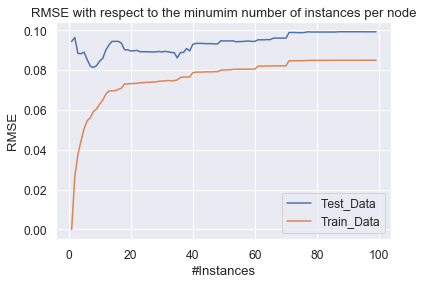

In [144]:
"""
Plot the RMSE with respect to the minimum number of instances
""" 
fig = plt.figure()
ax0 = fig.add_subplot(111) 
RMSE_train = []
RMSE_test = []
for i in range(1,100):
    #Paramterize the model and let i be the number of minimum instances per leaf node
    regression_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=i)   
    #Train the model
    regression_model.fit(X_train, y_train)
    #Predict query instances
    predicted_train = regression_model.predict(X_train)
    predicted_test = regression_model.predict(X_test)
    #Calculate and append the RMSEs
    RMSE_train.append(np.sqrt(mean_squared_error(y_train, predicted_train)))
    RMSE_test.append(np.sqrt(mean_squared_error(y_test, predicted_test)))
   
ax0.plot(range(1,100),RMSE_test,label='Test_Data')
ax0.plot(range(1,100),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()

In [169]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)

# print(result)
print(g_cv.best_params_)
print(r2_score(y_test, g_cv.best_estimator_.predict(X_test)))

{'min_samples_split': 6}
0.32156501228200596


/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


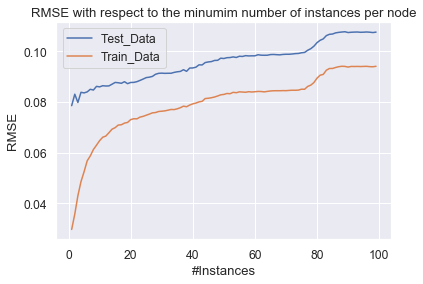

In [157]:
"""
Plot the RMSE with respect to the minimum number of instances
""" 
fig = plt.figure()
ax0 = fig.add_subplot(111) 
RMSE_train = []
RMSE_test = []
for i in range(1,100):
    #Paramterize the model and let i be the number of minimum instances per leaf node
    regression_model = RandomForestRegressor(criterion="mse", n_estimators = 100, min_samples_leaf=i)   
    #Train the model
    regression_model.fit(X_train, y_train)
    #Predict query instances
    predicted_train = regression_model.predict(X_train)
    predicted_test = regression_model.predict(X_test)
    #Calculate and append the RMSEs
    RMSE_train.append(np.sqrt(mean_squared_error(y_train, predicted_train)))
    RMSE_test.append(np.sqrt(mean_squared_error(y_test, predicted_test)))
   
ax0.plot(range(1,100),RMSE_test,label='Test_Data')
ax0.plot(range(1,100),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()

In [186]:
scoring = make_scorer(r2_score)
g_cv = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=100),
              param_grid={'min_samples_split': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

# print(result)
print(g_cv.best_params_)
print(r2_score(y_test, g_cv.best_estimator_.predict(X_test)))

/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 8}
0.5437584226417236


In [ ]:
from sklearn.svm import SVR

X = X.values()
y = y.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

# Look at the results
lw = 2
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/halliecramer/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' 